# RobustRandomCutForest implementation using MSTICPy library with small 4-dimensional sample data

In [9]:
import msticpy as mp

print(mp.__version__)
mp.init_notebook()

2025-05-27 07:53:55,729: WARNING - Could not find msticpyconfig.yaml in standard search. (nbinit#737)


2.16.2


## Phase 1. Loading sample datasets from MSTICPy's prepared Azure netflow data

In [2]:
# MSTICPy is Microsoft's threat intelligence library designed for security analytics
import numpy as np
import pandas as pd

# loading csv file to dataframe
az_net_flows_df = pd.read_csv(
    "data/az_net_flows.csv",
    parse_dates=["TimeGenerated", "FlowStartTime", "FlowEndTime"],
    infer_datetime_format=True,
    index_col=0,
)

# plot to msticpy's builtin viz timeline chart
az_net_flows_df.mp_plot.timeline_values(
    group_by="L7Protocol",
    source_columns=[
        "FlowType",
        "AllExtIPs",
        "L7Protocol",
        "FlowDirection",
        "TotalAllowedFlows",
    ],
    time_column="FlowStartTime",
    y="TotalAllowedFlows",
    legend="right",
    height=500,
);

Loading BokehJS ...


## Phase2. (Preprocessing) Pivot azure net flow data to timeseries per 5min

In [ ]:
import pandas as pd

# Round down 'FlowStartTime' to the nearest 5 minutes to create time bins
az_net_flows_df["FlowStartTime_5min"] = az_net_flows_df["FlowStartTime"].dt.floor("5T")

# Get the full range of 5-minute intervals between the minimum and maximum times
full_time_range = pd.date_range(
    start=az_net_flows_df["FlowStartTime_5min"].min(),
    end=az_net_flows_df["FlowStartTime_5min"].max(),
    freq="5T",
)

# Get all unique L7Protocol values
all_protocols = az_net_flows_df["L7Protocol"].unique()

# Create a MultiIndex of all combinations of time intervals and protocols
full_index = pd.MultiIndex.from_product(
    [full_time_range, all_protocols], names=["FlowStartTime_5min", "L7Protocol"]
)

# Group by the 5-minute interval and 'L7Protocol', then count the number of flows in each group
grouped = az_net_flows_df.groupby(["FlowStartTime_5min", "L7Protocol"]).size()

# Reindex the grouped data to include all combinations, filling missing values with 0
grouped_full = grouped.reindex(full_index, fill_value=0).reset_index(name="FlowCount")

# Pivot the table so that each 'L7Protocol' value becomes a separate column
pivot_df = grouped_full.pivot(
    index="FlowStartTime_5min", columns="L7Protocol", values="FlowCount"
)

# Replace NaN values with 0 and convert to integer type
pivot_df = pivot_df.fillna(0).astype(int)

# Optionally, reset the index if you want 'FlowStartTime_5min' as a regular column
pivot_df = pivot_df.reset_index()

print(f"\nDataFrame columns: {pivot_df.columns.tolist()}")
print(f"DataFrame shape: {pivot_df.shape}")
print("\nFirst 5 rows of the dataset:")
display(pivot_df.head())
print("\nLast 5 rows of the dataset:")
display(pivot_df.tail())

## Phase 3. Execute anomaly detection using MSTICPy's identify_outliers function


In [ ]:
from msticpy.analysis.outliers import identify_outliers_rrcf, plot_outlier_results

# Execute anomaly detection using MSTICPy's identify_outliers_rrcf function
# This function wraps scikit-learn's RobustRandomCutForest with security analytics optimizations
print("\nExecuting Isolation Forest anomaly detection...")

feature_columns = pivot_df.columns.tolist()[1:]

# Use all features for training and prediction
all_features_data = pivot_df[feature_columns].values

clf, detected_outliers, prediction_labels = identify_outliers_rrcf(
    x=all_features_data,  # Training data (all features)
    x_predict=all_features_data,  # Prediction data (same as training for this example)
    contamination=0.01,  # Expected proportion of outliers (default: 0.05)
    max_features=len(feature_columns),  # Use all available features for each tree
)

print("Isolation Forest model trained successfully")
print(f"Number of detected outlier data points: {len(detected_outliers)}")
print(f"Shape of detected outliers array: {detected_outliers.shape}")

# Analyze and display detection results
anomaly_count = sum(prediction_labels == -1)
normal_count = sum(prediction_labels == 1)

print("\n=== ANOMALY DETECTION RESULTS ===")
print(f"Total data points analyzed: {len(prediction_labels)}")
print(f"Anomalies detected: {anomaly_count}")
print(f"Normal points identified: {normal_count}")

# Add prediction results to the DataFrame for comprehensive analysis
pivot_df["anomaly_prediction"] = (
    prediction_labels  # Binary classification (-1: anomaly, 1: normal)
)
pivot_df["is_anomaly"] = prediction_labels == -1  # Boolean flag for easier filtering


Executing Isolation Forest anomaly detection...


Building trees:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Isolation Forest model trained successfully
Number of detected outlier data points: 6
Shape of detected outliers array: (6, 7)

=== ANOMALY DETECTION RESULTS ===
Total data points analyzed: 570
Anomalies detected: 6
Normal points identified: 564


## Phase 4. Display detailed information about detected anomalies

In [ ]:
print("\n=== DETECTED ANOMALIES ANALYSIS ===")
anomalies_df = pivot_df[pivot_df["is_anomaly"]].copy()

if len(anomalies_df) > 0:
    print(f"Detected {len(anomalies_df)} anomalous data points:")
    print("\nAnomaly details:")

    for idx, (row_idx, row) in enumerate(anomalies_df.iterrows()):
        print(f"\nAnomaly #{idx + 1} (Row {row_idx}):")
        # print(f"  Anomaly Score: {row['anomaly_score']:.4f}")
        feature_values = ", ".join([f"{col}: {row[col]:.3f}" for col in feature_columns])
        print(f"  Feature Values: {feature_values}")

        # Calculate distance from origin as additional anomaly indicator
        feature_vector = row[feature_columns].values
        distance_from_origin = np.linalg.norm(feature_vector)
        print(f"  Distance from Origin: {distance_from_origin:.3f}")

    # Statistical summary of anomalies
    print("\n=== ANOMALY STATISTICS ===")

    print("\nFeature statistics for detected anomalies:")
    for feature in feature_columns:
        feature_stats = anomalies_df[feature].describe()
        print(
            f"{feature}: mean={feature_stats['mean']:.3f}, "
            f"std={feature_stats['std']:.3f}, "
            f"range=[{feature_stats['min']:.3f}, {feature_stats['max']:.3f}]"
        )

else:
    print("No anomalies were detected in the dataset.")

display(pivot_df.tail())


=== DETECTED ANOMALIES ANALYSIS ===
Detected 6 anomalous data points:

Anomaly details:

Anomaly #1 (Row 85):
  Feature Values: ftp: 0.000, http: 9.000, https: 18.000, microsoft-ds: 0.000, ms-wbt-server: 0.000, ntp: 1.000, ssh: 0.000
  Distance from Origin: 20.149

Anomaly #2 (Row 106):
  Feature Values: ftp: 0.000, http: 8.000, https: 3.000, microsoft-ds: 0.000, ms-wbt-server: 0.000, ntp: 0.000, ssh: 1.000
  Distance from Origin: 8.602

Anomaly #3 (Row 107):
  Feature Values: ftp: 0.000, http: 0.000, https: 2.000, microsoft-ds: 0.000, ms-wbt-server: 0.000, ntp: 0.000, ssh: 2.000
  Distance from Origin: 2.828

Anomaly #4 (Row 112):
  Feature Values: ftp: 0.000, http: 0.000, https: 0.000, microsoft-ds: 0.000, ms-wbt-server: 0.000, ntp: 0.000, ssh: 1.000
  Distance from Origin: 1.000

Anomaly #5 (Row 143):
  Feature Values: ftp: 0.000, http: 0.000, https: 1.000, microsoft-ds: 2.000, ms-wbt-server: 0.000, ntp: 0.000, ssh: 0.000
  Distance from Origin: 2.236

Anomaly #6 (Row 470):
  Featu

L7Protocol,FlowStartTime_5min,ftp,http,https,microsoft-ds,ms-wbt-server,ntp,ssh,anomaly_prediction,is_anomaly
565,2019-02-14 12:05:00,0,0,0,0,0,0,0,1,False
566,2019-02-14 12:10:00,0,0,0,0,0,0,0,1,False
567,2019-02-14 12:15:00,0,0,0,0,0,0,0,1,False
568,2019-02-14 12:20:00,0,0,1,0,0,0,0,1,False
569,2019-02-14 12:25:00,0,0,1,0,0,0,0,1,False


## Phase 5. Visualize results using MSTICPy's built-in plotting function


Generating anomaly detection visualization...


Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

Scoring trees per 256 rows:   0%|          | 0/100 [00:00<?, ?it/s]

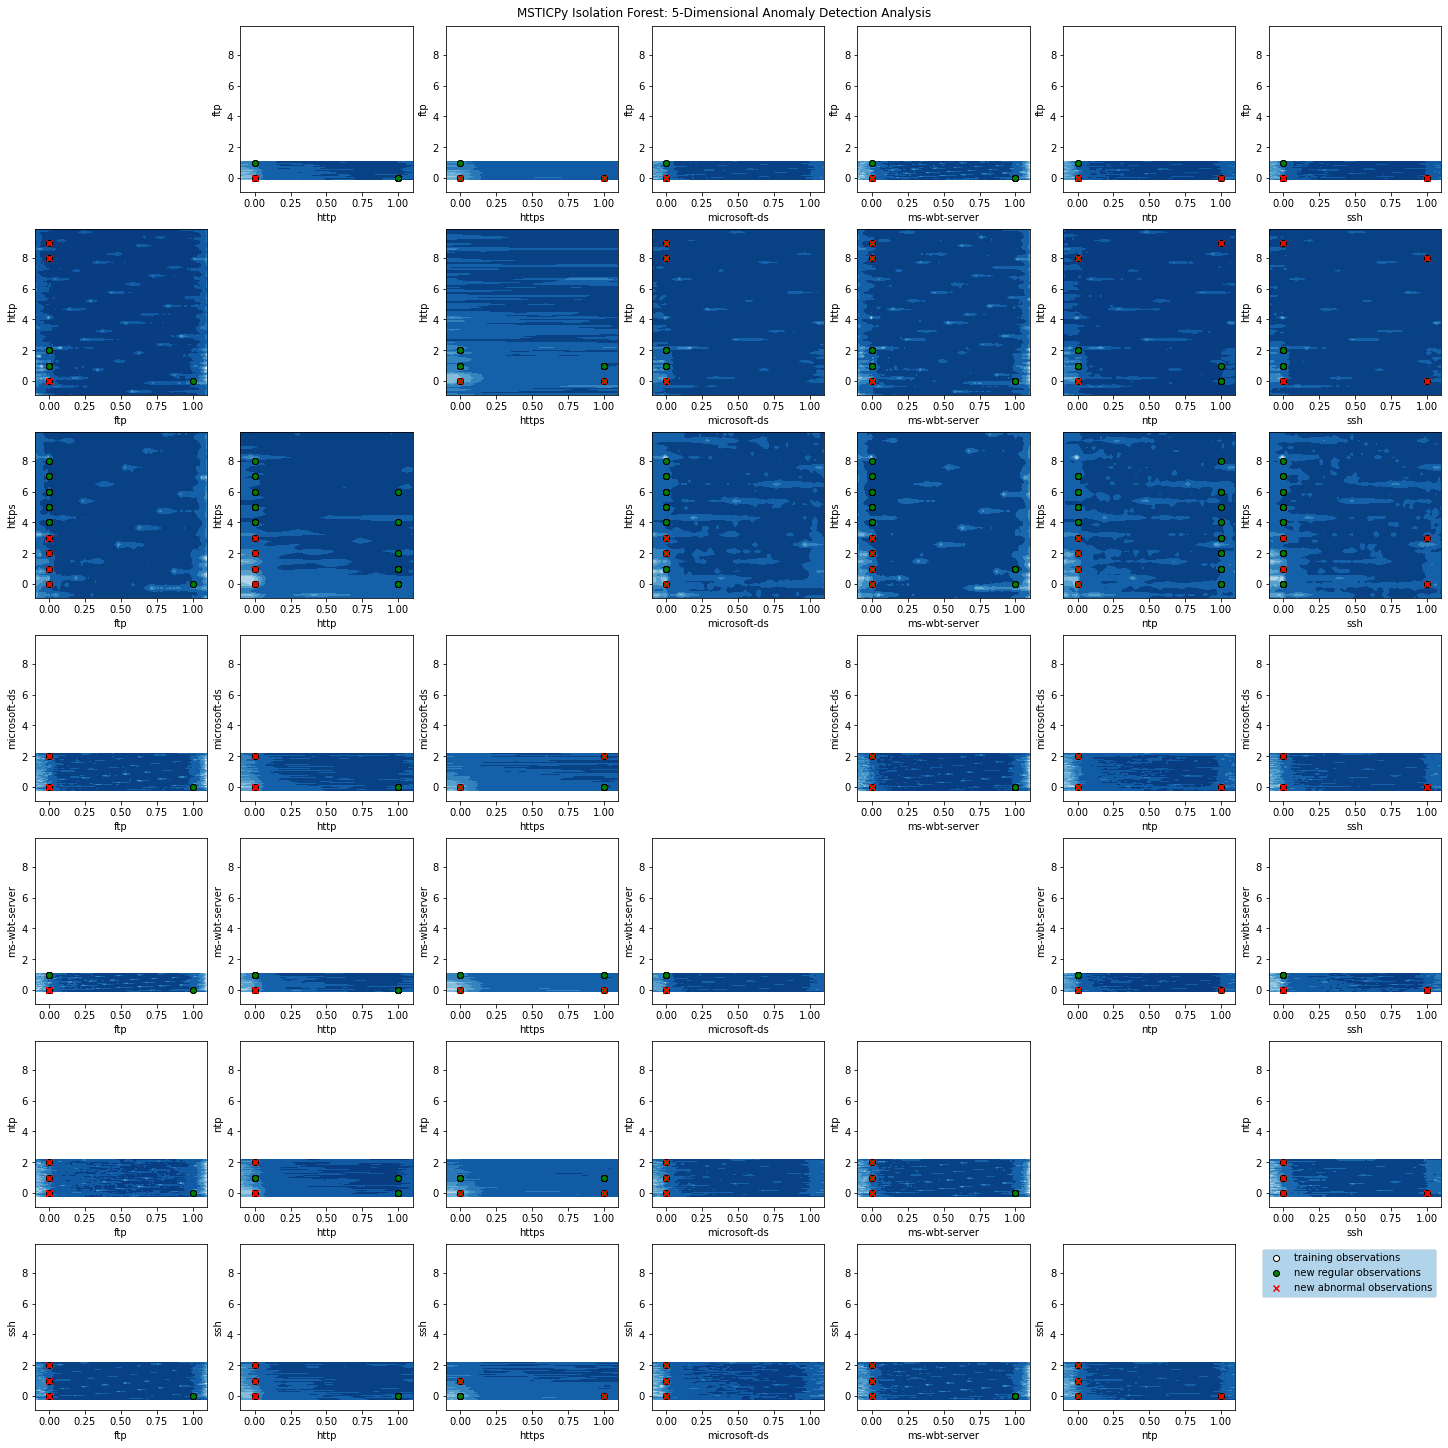


=== DATA EXPORT ===
Complete dataset with anomaly predictions available in 'pivot_df' DataFrame
Columns available: ['FlowStartTime_5min', 'ftp', 'http', 'https', 'microsoft-ds', 'ms-wbt-server', 'ntp', 'ssh', 'anomaly_prediction', 'is_anomaly']
Use pivot_df[df['is_anomaly']] to access detected anomalies
Use pivot_df[~df['is_anomaly']] to access normal data points


In [6]:
print("\nGenerating anomaly detection visualization...")
plot_outlier_results(
    clf=clf,  # Trained Isolation Forest model
    x=all_features_data,  # Original training data
    x_predict=all_features_data,  # Prediction data
    x_outliers=detected_outliers,  # Detected outlier points
    feature_columns=feature_columns,  # Use feature indices
    plt_title="MSTICPy Isolation Forest: 5-Dimensional Anomaly Detection Analysis",
)

# Save results for further analysis (optional)
print("\n=== DATA EXPORT ===")
print("Complete dataset with anomaly predictions available in 'pivot_df' DataFrame")
print(f"Columns available: {pivot_df.columns.tolist()}")
print("Use pivot_df[df['is_anomaly']] to access detected anomalies")
print("Use pivot_df[~df['is_anomaly']] to access normal data points")

## Phase 6. timeline visualization for anomaly timerange per each L7protocol with MSTICPy's display_timeseries_anomolies

In [ ]:
## Time Series Graph
from msticpy.nbtools.timeseries import display_timeseries_anomolies

for column_name in feature_columns:
    pivot_df["baseline"] = pivot_df[column_name]
    # If the is_anomaly column is True, set the abnormal column to 1, otherwise set it to 0
    pivot_df["anomalies"] = (pivot_df["is_anomaly"]).astype(int)

    timeseries_anomalies_plot = display_timeseries_anomolies(
        data=pivot_df, y=column_name, time_column="FlowStartTime_5min"
    )
    display(f"for {column_name} timeline")

    pivot_df.drop("baseline", axis=1, inplace=True)
    pivot_df.drop("anomalies", axis=1, inplace=True)

Loading BokehJS ...

2025-05-26 19:38:04,094: ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='score' [no close matches] {renderer: GlyphRenderer(id='p1450', ...)} (check#210)


'for ftp timeline'

Loading BokehJS ...

2025-05-26 19:38:04,256: ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='score' [no close matches] {renderer: GlyphRenderer(id='p1674', ...)} (check#210)


'for http timeline'

Loading BokehJS ...

2025-05-26 19:38:04,420: ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='score' [no close matches] {renderer: GlyphRenderer(id='p1898', ...)} (check#210)


'for https timeline'

Loading BokehJS ...

2025-05-26 19:38:04,582: ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='score' [no close matches] {renderer: GlyphRenderer(id='p2122', ...)} (check#210)


'for microsoft-ds timeline'

Loading BokehJS ...

2025-05-26 19:38:04,733: ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='score' [no close matches] {renderer: GlyphRenderer(id='p2346', ...)} (check#210)


'for ms-wbt-server timeline'

Loading BokehJS ...

2025-05-26 19:38:04,888: ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='score' [no close matches] {renderer: GlyphRenderer(id='p2570', ...)} (check#210)


'for ntp timeline'

Loading BokehJS ...

2025-05-26 19:38:05,044: ERROR - E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : y='score' [no close matches] {renderer: GlyphRenderer(id='p2794', ...)} (check#210)


'for ssh timeline'

In [8]:
# anomaly detected timerange
pivot_df[pivot_df["is_anomaly"]]

L7Protocol,FlowStartTime_5min,ftp,http,https,microsoft-ds,ms-wbt-server,ntp,ssh,anomaly_prediction,is_anomaly
85,2019-02-12 20:05:00,0,9,18,0,0,1,0,-1,True
106,2019-02-12 21:50:00,0,8,3,0,0,0,1,-1,True
107,2019-02-12 21:55:00,0,0,2,0,0,0,2,-1,True
112,2019-02-12 22:20:00,0,0,0,0,0,0,1,-1,True
143,2019-02-13 00:55:00,0,0,1,2,0,0,0,-1,True
470,2019-02-14 04:10:00,0,0,3,0,0,2,0,-1,True


## Conclusion

Comparing among the jupyter notebooks in [

    Outliers-IsolationForest.ipynb,
    
    Outliers-IsolationForest_timeseries.ipynb,
    
    Outliers-RobustRandomCutForest.ipynb,
    
    Outliers-RobustRandomCutForest_timeseries.ipynb,

], 

You can find the differences between IsolationForest and RobustRandomCutForest for some anomaly detected points.

For time series data, IsolationForest is known to be effective at detecting simple spikes, while RRCF is effective at detecting `trend changes and correlations in multidimensional` features. 

To sum up, RRCF is good at detecting time-series change points when complex correlated anomalies and data distributions change over time!


